In [15]:
import matplotlib.pyplot as plt
import networkx as nx
import hypernetx as hnx
import numpy as np
import pandas as pd
import os
import argparse

## hypergraph vis

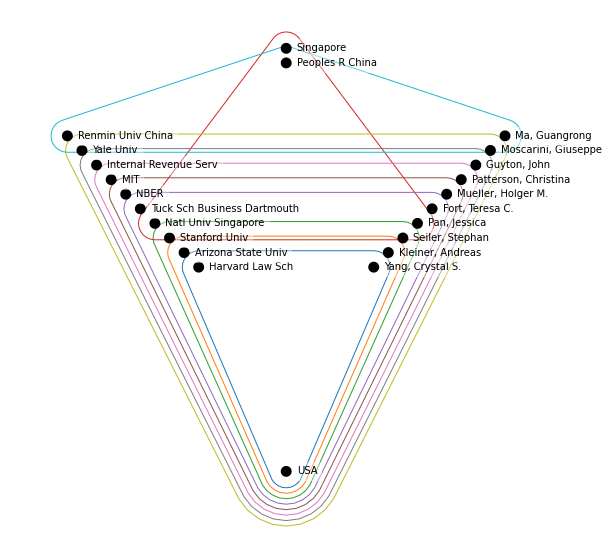

In [33]:
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.src = '../data/csv/AMERICAN ECONOMIC REVIEW.csv'
args.year = ['2017']
args.size = 10
args.seed = 0

df = pd.read_csv(args.src, index_col=None)

if args.year:
    df = df.loc[df['DBYear'].isin(args.year), :]

# convert name to id
colName = ['Fullname', 'Country', 'FullOrgName']
clusterCenter = [(args.size*30, -args.size*30), (0, args.size*50), (-args.size*30, -args.size*30)]
dirc = [(args.size*5, args.size*5), (0, -args.size*5), (-args.size*5, args.size*5)]
nickName = ['Researcher', 'Country', 'Organization']

# add edges
df_sub = df.sample(n=args.size, random_state=args.seed)
hyperedges = dict(zip(df_sub.index, list(zip(*[df_sub[col] for col in colName]))))
#for col in colName:
#    hyperedges[col] = list(df_sub[col].unique())

pos = {}
for col, center, d in zip(colName, clusterCenter, dirc):
    for i, name in enumerate(df_sub[col].unique()):
        # USA is so fat that it will affect other edges
        # thus we isolate its position to bottom right
        if name == 'USA':
            pos[name] = (0, -args.size*100)
        else:
            pos[name] = (center[0]+d[0]*i, center[1]+d[1]*i)

H = hnx.Hypergraph(hyperedges)
plt.figure(figsize=(10, 10))
hnx.draw(H, pos=pos, with_edge_labels=False, edge_labels=df_sub['ArticleNumber'])
plt.show()

## run all journal & years

In [ ]:
f_path = ['AMERICAN ECONOMIC REVIEW.csv', 'JOURNAL OF POLITICAL ECONOMY.csv', 'ECONOMETRICA.csv', 'REVIEW OF ECONOMIC STUDIES.csv']
nickname = ['AMERICAN ECONOMIC REVIEW', 'JOURNAL OF POLITICAL ECONOMY', 'Econometrica', 'REVIEW OF ECONOMIC STUDIES']
command = 'python3 csv_calc_eigenvalue.py --src \'../data/csv/{}\' --year {} --out \'out/{}_{}.csv\''
!pwd

In [ ]:
import os
for f, n in zip(f_path, nickname):
    try:
        year = pd.read_csv('../data/csv/{}'.format(f), index_col=0)['DBYear'].unique()
        for y in year:
            s = command.format(f, y, n, y)
            print(s)
            os.system(s)
    except:
        s = 'python3 csv_calc_eigenvalue.py --src \'../data/csv/{}\' --out \'out/{}_all.csv\''.format(f, n)
        print(s)
        os.system(s)

## store result into single csv

In [34]:
df = pd.DataFrame(columns=['centrality', 'name', 'group', 'year', 'journal'])
for f in os.listdir('./out'):
    _df = pd.read_csv('./out/{}'.format(f))
    journal, year = f.strip('.csv').split('_')
    _df['year'] = year
    _df['journal'] = journal
    df = df.merge(_df, how='outer')

df.to_csv('all_centrality_by_year_by_journal.csv')

In [35]:
df

,centrality,name,group,year,journal
0,9.773390e-01,USA,Country,2017,AMERICAN ECONOMIC REVIEW
1,1.636040e-01,NBER,FullOrgName,2017,AMERICAN ECONOMIC REVIEW
2,5.139606e-02,MIT,FullOrgName,2017,AMERICAN ECONOMIC REVIEW
3,4.602251e-02,Harvard Univ,FullOrgName,2017,AMERICAN ECONOMIC REVIEW
4,4.067859e-02,Stanford Univ,FullOrgName,2017,AMERICAN ECONOMIC REVIEW
...,...,...,...,...,...
6866,1.840660e-18,Japan,Country,all,Econometrica
6867,1.523125e-18,"Noguchi, Yuichi",Fullname,all,Econometrica
6868,1.314932e-18,"Preinerstorfer, David",Fullname,all,Econometrica
6869,8.368454e-19,"Demuynck, Thomas",Fullname,all,Econometrica


## plot centrality and ranking graph per journal

In [10]:
def draw(col, col2, topk, year, nickname):
    # retrieve topk from each year
    sheets = []
    for y in year:
        _df = pd.read_csv('./out/{}_{}.csv'.format(nickname, y))
        _df = _df.loc[_df['group'] == col, :].reset_index()
        sheets.append(_df)

    name_topks = set()
    for sheet in sheets:
        name_topks.update(sheet[:topk]['name'])

    # retrieve rank
    rks = {}
    for name in name_topks:
        if col2 == 'rank':
            rk = [sheet.loc[sheet['name'] == name, :].index for sheet in sheets]
            rks[name] = [r[0]+1 if len(r) > 0 else -1 for r in rk]
        else:
            rk = [sheet.loc[sheet['name'] == name, col2] for sheet in sheets]
            rks[name] = [r.iloc[0] if len(r) > 0 else -1 for r in rk]
                    
        
    # plot
    plt.figure(figsize=(8, 5))
    for name in name_topks:
        # USA's centrality is too high
        if name == 'USA' and col2 == 'centrality':
            continue
        res = []
        x = []
        for i, r in enumerate(rks[name]):
            if r > 0:
                res.append(r)
                x.append(i)
        plt.plot(x, res, '-o', label=name)

    plt.title(nickname)
    plt.xticks(range(len(year)), year)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    if col2 == 'rank':
        plt.gca().invert_yaxis()
    plt.show()

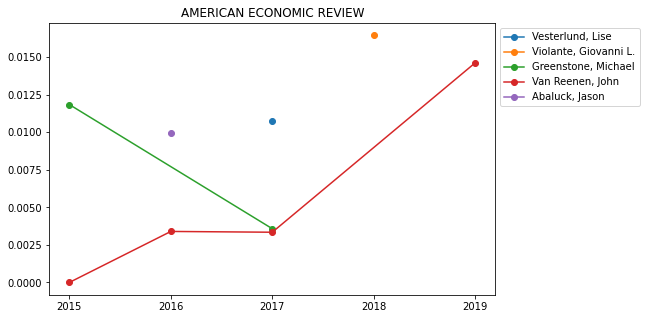

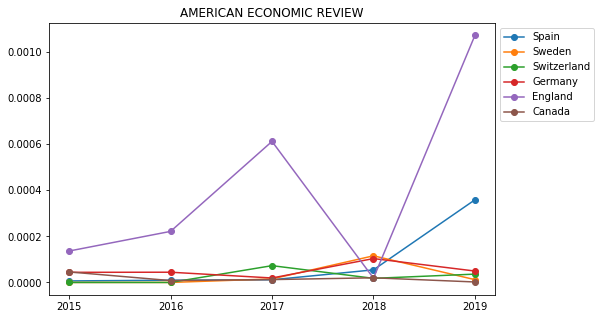

In [11]:
# ex: AMERICAN ECONOMIC REVIEW, centrality
draw('Fullname', 'centrality', 1, range(2015, 2020), 'AMERICAN ECONOMIC REVIEW')
draw('Country', 'centrality', 3, range(2015, 2020), 'AMERICAN ECONOMIC REVIEW')

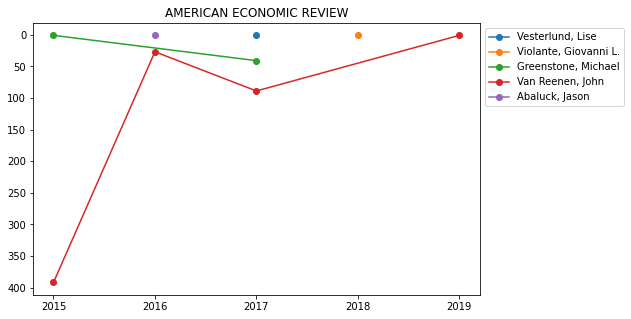

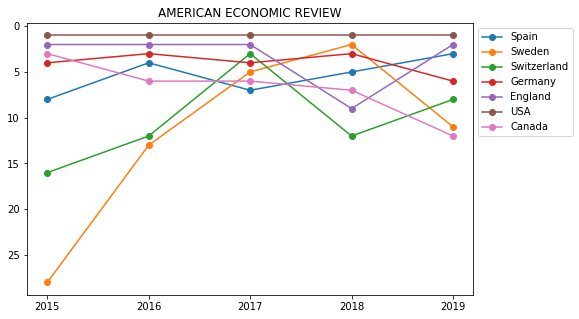

In [12]:
# ex: AMERICAN ECONOMIC REVIEW, rank
draw('Fullname', 'rank', 1, range(2015, 2020), 'AMERICAN ECONOMIC REVIEW')
draw('Country', 'rank', 3, range(2015, 2020), 'AMERICAN ECONOMIC REVIEW')